# 2.0 - Drug response of CCLE samples

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch

import os
import sys
sys.path.append(f"../")
from sslcox.utils.model_evaluation import model_already_trained
from sslcox.data.load_datasets import load_CCLE

In [2]:
EXPRESSIONS = 'CCLE'

DS_DIR = f'{EXPRESSIONS}-optuna'
CV_DIR = lambda cv: f'CV-{cv}'
MODEL_DIR = lambda m: f'{m}-model-results'

In [3]:
training_results = []

for cv in sorted(os.listdir(f'../data/training-results/{DS_DIR}')):
    if cv.startswith('.'): continue
    cv_results = {}

    for model in os.listdir(f'../data/training-results/{DS_DIR}/{cv}'):
        if model.startswith('.'): continue

        name = model.split('-model-results')[0]
        base_path = f'../data/training-results/{DS_DIR}/{cv}/{model}'

        if not model_already_trained(DS_DIR, CV_DIR(cv.split('-')[1]), MODEL_DIR(name)):
            continue

        X_train_latent = pd.read_csv(f'{base_path}/X_train_latent.tsv', sep='\t', index_col=['index'])
        X_test_latent = pd.read_csv(f'{base_path}/X_test_latent.tsv', sep='\t', index_col=['index'])
        
        cv_results[name] = {
            'X_train_latent': X_train_latent,
            'X_test_latent': X_test_latent,
        }
        
        
    training_results += [cv_results]

In [4]:
drugs = load_CCLE()[2]
drugs.head()

/opt/homebrew/Caskroom/miniforge/base/envs/ssl-latent/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,123138,123829,150412,5-Fluorouracil,5-azacytidine,50869,615590,630600,667880,720427,...,WZ4003,Wee1 Inhibitor,Wnt-C59,XAV939,YK-4-279,ZM447439,Zoledronate,alpha-lipoic acid,ascorbate (vitamin C),glutathione
906826,4.754414,0.82921,4.170798,7.129417,3.916871,5.271327,4.753674,0.513277,3.226811,4.504797,...,6.441645,2.770545,6.561959,7.018388,4.114274,7.05112,4.761329,9.452854,12.218334,10.763684
687983,2.961674,3.969147,3.404055,7.308453,4.062533,2.141208,3.261791,2.096243,-0.672773,2.969287,...,5.642067,2.994126,4.841027,4.902027,1.549137,2.375695,4.019365,8.270719,10.811844,9.308347
910927,2.863059,1.203408,2.205815,3.3306,2.426967,1.66797,2.861703,0.619342,-0.638068,3.206737,...,5.421666,0.703313,3.845436,3.941939,1.125049,3.787239,4.004508,7.185137,9.596964,8.364352
1240138,2.086041,3.779251,4.11627,5.886689,NaN,4.345005,4.802093,3.961821,1.823284,4.008186,...,4.722434,5.192086,5.899062,3.708712,4.570317,3.906759,4.393106,NaN,NaN,NaN
1240139,NaN,NaN,NaN,2.230731,NaN,NaN,NaN,NaN,NaN,NaN,...,5.447572,1.253851,2.961875,4.262296,3.307553,2.334749,NaN,NaN,NaN,NaN


## Modeling transcription and decay enrichment

In [5]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold
from tqdm import tqdm

RIDGE_PARAMS = {
    'alpha': [0.1, 1, 10, 100],
    #'kernel': ['linear', 'rbf'],
    #'gamma': [0.01, 0.1, 1]
    #'n_neighbors': [5, 10, 20, 50],
    #'weights': ['uniform', 'distance'],
}
MIN_DRUG_RESPONSES = 500

top_drugs = ((drugs.fillna(0)>0).sum(axis=0).sort_values(ascending=False) >= MIN_DRUG_RESPONSES).index.values

ridge_models = {}
predictions = {}
performance = {}

for cv in range(len(training_results)):
    ridge_models[cv] = {}
    predictions[cv] = {}
    performance[cv] = {}

    for model, values in tqdm(training_results[cv].items()):
        ridge_models[cv][model] = {}
        predictions[cv][model] = {}
        performance[cv][model] = {}

        for process in top_drugs:
            X_train = values['X_train_latent']
            X_test = values['X_test_latent']

            y_train = drugs[process].loc[X_train.index].dropna()
            y_test = drugs[process].loc[X_test.index].dropna()

            X_train = X_train.loc[y_train.index]
            X_test = X_test.loc[y_test.index]

            X_train_mean, X_train_std = X_train.mean(axis=0), X_train.std(axis=0)
            X_train = (X_train - X_train_mean)/X_train_std
            X_test = (X_test - X_train_mean)/X_train_std

            y_train_mean, y_train_std = y_train.mean(), y_train.std()
            y_train = (y_train - y_train_mean)/y_train_std
            y_test = (y_test - y_train_mean)/y_train_std

            estimator = Ridge()
            loo = KFold(n_splits=10)

            grid_search = GridSearchCV(estimator, RIDGE_PARAMS, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)

            ridge_models[cv][model][process] = grid_search

            y_pred = grid_search.predict(X_test)
            predictions[cv][model][process] = y_pred

            score = r2_score(y_test, y_pred)
            performance[cv][model][process] = score
        

100%|██████████| 5/5 [02:24<00:00, 29.00s/it]


In [7]:
results = {
    name: {
        d: [per[name][d] for per in performance.values()]
        for d in top_drugs
    }
    for name in performance[0].keys()
}

results = {name: results[name] for name in ['vae-cox', 'vae-mse', 'vae-div', 'pca-emb', 'no-embedding']}

In [9]:
mean_results = pd.DataFrame(
    [[np.mean(results[name][d]) for name in results.keys()] for d in top_drugs],
    index=top_drugs, columns=results.keys()
)
mean_results.head()

,vae-cox,vae-mse,vae-div,pca-emb,no-embedding
Olaparib,0.470167,0.452620,0.460781,0.470023,0.403015
Temozolomide,0.437351,0.395079,0.421959,0.419869,0.271488
MIRA-1,0.491830,0.448465,0.474572,0.481237,0.335949
GSK343,0.257916,0.223372,0.243679,0.249729,-0.012586
EPZ004777,0.380957,0.334245,0.357990,0.355671,0.139901


In [12]:
ranks = pd.DataFrame(np.argsort(np.argsort(mean_results.values*-1))+1, columns=mean_results.columns)

for col in ranks.columns:
    mu, std = ranks[col].mean(), ranks[col].std()/np.sqrt(len(ranks))
    print(f"{col:10s} \({mu:.2f} \pm {std:.2f}\) ")


vae-cox    \(1.26 \pm 0.04\) 
vae-mse    \(3.66 \pm 0.04\) 
vae-div    \(2.92 \pm 0.04\) 
pca-emb    \(2.17 \pm 0.04\) 
no-embedding \(5.00 \pm 0.00\) 


In [13]:
average_ranks = np.argsort(np.argsort(mean_results.values*-1)).mean(axis=0) + 1
average_ranks

array([1.25524476, 3.66083916, 2.91608392, 2.17132867, 4.9965035 ])

In [14]:
import numpy as np
from sslcox.metrics.critical_difference import compute_CD, graph_ranks

In [16]:
cd = compute_CD(average_ranks, len(mean_results))
cd

0.36067029175477644

In [17]:
mean_results.columns

Index(['vae-cox', 'vae-mse', 'vae-div', 'pca-emb', 'no-embedding'], dtype='object')

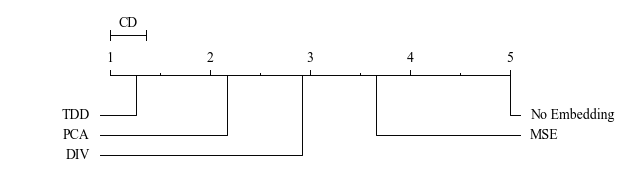

In [18]:
plt.rcParams["font.family"] = "Times New Roman"

names = ['TDD', 'MSE', 'DIV', 'PCA', 'No Embedding']
graph_ranks(average_ranks, names, cd, filename='../figures/CD-CCLE-drug-response.pdf', **{'dpi':300, 'bbox_inches':'tight'})

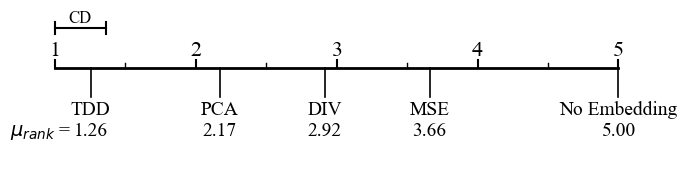

In [103]:
f, ax = plt.subplots(1, 1, figsize=(8,2))

ax.plot([1,5], [0,0], lw=2, c='k')

for i in range(1,6):
    ax.plot([i,i],[0,0.08], c='k', lw=1.5)

    ax.text(i, 0.12, i, c='k', fontsize=16, ha='center')

for i in range(1,5):
    ax.plot([i+0.5,i+0.5],[0,0.05], c='k', lw=1)

ax.plot([1,1], [0.35, 0.48], c='k',)
ax.plot([1+cd,1+cd], [0.35, 0.48], c='k')
ax.plot([1,1+cd], [0.41, 0.41], c='k')
ax.text(1+cd/2, 0.47, 'CD', fontsize=12, ha='center')

ax.set_ylim(top=0.6, bottom=-1)

for name, mean_rank, mean_std in zip(names, ranks.mean().values, ranks.std().values/len(ranks)):

    ax.plot([mean_rank, mean_rank], [-0.3, 0], lw=1.2, c='k')
    
    ax.text(mean_rank, -0.35, f'{name}\n{mean_rank:.2f}', va='top', ha='center', fontsize=14)

ax.text(0.9, -0.35, f'\n$\mu_{{rank}}$ = ', va='top', ha='center', fontsize=14)

ax.set_xticks([])
ax.set_yticks([])
for loc in ['top', 'bottom', 'left', 'right']:
    ax.spines[loc].set_visible(False)


